In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import Adam


#Librerías optimizacion por búsqueda aleatoria
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV


from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
maindf = pd.read_csv(r"/content/XAUUSD_D1.csv", sep="\t", parse_dates=["Time"], dayfirst=True)

In [4]:
maindf['Time'] = pd.to_datetime(maindf['Time'], format='%Y-%m-%d')

maindf = maindf.loc[(maindf['Time'] >= '2006-12-31')
                     & (maindf['Time'] <= '2022-12-01')]


In [5]:
# Separamos los valores de cierre
closedf = maindf[['Time','Close']]
print("Shape de closedf:", closedf.shape)

Shape de closedf: (4961, 2)


In [6]:
close_stock = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  4961


In [7]:
del closedf['Time']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(4961, 1)


In [8]:
training_size=int(len(closedf)*0.75)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (3720, 1)
test_data:  (1241, 1)


In [9]:
# Convierte un array de valores en un matriz dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
time_step = 3
train_X, train_y = create_dataset(train_data, time_step)
test_X, test_y = create_dataset(test_data, time_step)

print("X_train: ", train_X.shape)
print("y_train: ", train_y.shape)
print("X_test: ", test_X.shape)
print("y_test", test_y.shape)

X_train:  (3716, 3)
y_train:  (3716,)
X_test:  (1237, 3)
y_test (1237,)


In [11]:
# reshape input to be [samples, time steps, features] which is required for LSTM
train_X =train_X.reshape(train_X.shape[0],train_X.shape[1] , 1)
test_X = test_X.reshape(test_X.shape[0],test_X.shape[1] , 1)

print("X_train: ", train_X.shape)
print("X_test: ", test_X.shape)

X_train:  (3716, 3, 1)
X_test:  (1237, 3, 1)


In [12]:
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import Bidirectional

def create_model(n_layers, n_neurons, dropout_rate, lr):
    model = Sequential()
    
    for i in range(n_layers):
        if i == 0:
            model.add(Bidirectional(LSTM(n_neurons, activation=tanh, input_shape=train_X.shape[1:], return_sequences=True)))
        else:
            model.add(Bidirectional(LSTM(n_neurons, activation=tanh, return_sequences=True)))
        model.add(Dropout(dropout_rate))
    model.add(LSTM(n_neurons, activation=tanh))
    model.add(Dense(1, activation='linear'))
    optimizer = Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [13]:
#Esta es la funcion objetivo que tengo en optimizacion bayesiana
from tensorflow.keras.callbacks import EarlyStopping

# Función para entrenar y evaluar el modelo con los hiperparámetros dados y devolver la pérdida
def objective(n_layers, dropout_rate, n_neurons, lr):
    # Convertir los valores de los hiperparámetros en los tipos adecuados
    n_layers = round(n_layers)
    n_neurons = round(n_neurons)
    # Crear el modelo con los hiperparámetros dados
    model = create_model(n_layers, dropout_rate, n_neurons, lr)
    # Entrenar el modelo con los datos de entrenamiento
    early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')
    model.fit(train_X, train_y, epochs=100, validation_split=0.1, callbacks=[early_stop], verbose=0)
    # Evaluar el modelo en el conjunto de prueba
    loss = -model.evaluate(test_X, test_y, verbose=0)
    return loss

In [ ]:
# Definimos los límites de los hiperparámetros

param_dist = {
    'n_layers': sp_randint(1, 6),
    'n_neurons': sp_randint(32, 150),
    'dropout_rate': sp_uniform(loc=0.0, scale=0.99),
    'lr': sp_uniform(loc=1e-10, scale=1e-2)
}

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


<ipython-input-16-b904e0e7cb97>:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  random_search = RandomizedSearchCV(estimator=KerasRegressor(build_fn=create_model), param_distributions=param_dist, n_iter=n_iter_search, cv=3)


In [ ]:
import joblib
# Esto ejecuta la celda en varios núcleos de CPU
with joblib.parallel_backend('multiprocessing', n_jobs=-1):
    random_search.fit(train_X, train_y)

32/39 [=======================>......] - ETA: 0s - loss: 0.0224

39/39 [==============================] - 5s 21ms/step - loss: 0.0187


39/39 [==============================] - 2s 4ms/step - loss: 0.0088


39/39 [==============================] - 1s 3ms/step - loss: 2.3705e-04


31/78 [==========>...................] - ETA: 4s - loss: 0.0602

39/39 [==============================] - 7s 26ms/step - loss: 6.3888e-05


39/39 [==============================] - 2s 10ms/step - loss: 0.0084


39/39 [==============================] - 2s 9ms/step - loss: 2.3088e-04


39/39 [==============================] - 3s 10ms/step - loss: 9.6938e-05


39/39 [==============================] - 3s 7ms/step - loss: 0.0303


39/39 [==============================] - 4s 6ms/step - loss: 4.3209e-04


18/78 [=====>........................] - ETA: 1s - loss: 0.1166

39/39 [==============================] - 3s 6ms/step - loss: 4.3413e-04


39/39 [==============================] - 2s 7ms/step - loss: 2.2911e-04


39/39 [==============================] - 2s 5ms/step - loss: 1.8159e-04


39/39 [==============================] - 2s 11ms/step - loss: 0.0033


39/39 [==============================] - 2s 8ms/step - loss: 2.4020e-04


24/78 [========>.....................] - ETA: 1s - loss: 0.0523

39/39 [==============================] - 2s 6ms/step - loss: 0.0033


39/39 [==============================] - 2s 9ms/step - loss: 2.4896e-04


39/39 [==============================] - 2s 8ms/step - loss: 5.7376e-05


39/39 [==============================] - 7s 21ms/step - loss: 0.0505


39/39 [==============================] - 4s 17ms/step - loss: 0.1234


39/39 [==============================] - 3s 6ms/step - loss: 0.0051


39/39 [==============================] - 2s 8ms/step - loss: 1.7791e-04


39/39 [==============================] - 4s 18ms/step - loss: 0.0219


39/39 [==============================] - 3s 6ms/step - loss: 2.7224e-04


39/39 [==============================] - 3s 13ms/step - loss: 0.0644


39/39 [==============================] - 2s 7ms/step - loss: 0.0756


39/39 [==============================] - 2s 11ms/step - loss: 0.0033


39/39 [==============================] - 5s 12ms/step - loss: 0.0103


39/39 [==============================] - 5s 17ms/step - loss: 2.1558e-04


39/39 [==============================] - 3s 11ms/step - loss: 1.1704e-04


39/39 [==============================] - 6s 19ms/step - loss: 0.0154


39/39 [==============================] - 7s 18ms/step - loss: 1.8361e-04


39/39 [==============================] - 5s 18ms/step - loss: 8.7812e-05


39/39 [==============================] - 4s 6ms/step - loss: 0.0226


39/39 [==============================] - 3s 6ms/step - loss: 0.0025


39/39 [==============================] - 4s 7ms/step - loss: 4.9404e-04


39/39 [==============================] - 1s 4ms/step - loss: 0.0054


16/78 [=====>........................] - ETA: 1s - loss: 0.0795

39/39 [==============================] - 2s 6ms/step - loss: 2.1286e-04


39/39 [==============================] - 2s 5ms/step - loss: 0.0154


39/39 [==============================] - 3s 7ms/step - loss: 0.0019


39/39 [==============================] - 3s 6ms/step - loss: 1.4127e-04


39/39 [==============================] - 5s 24ms/step - loss: 0.0875


39/39 [==============================] - 5s 23ms/step - loss: 0.0653


39/39 [==============================] - 5s 22ms/step - loss: 0.0015


39/39 [==============================] - 6s 25ms/step - loss: 0.0063


39/39 [==============================] - 6s 37ms/step - loss: 4.8674e-04


39/39 [==============================] - 3s 5ms/step - loss: 0.0150


39/39 [==============================] - 7s 28ms/step - loss: 1.6148e-04


39/39 [==============================] - 2s 7ms/step - loss: 2.6756e-04


39/39 [==============================] - 2s 5ms/step - loss: 2.0477e-04


39/39 [==============================] - 2s 6ms/step - loss: 0.0219


39/39 [==============================] - 3s 5ms/step - loss: 0.0010


39/39 [==============================] - 2s 6ms/step - loss: 5.4610e-04


69/78 [=========================>....] - ETA: 0s - loss: 0.0288

39/39 [==============================] - 3s 5ms/step - loss: 1.3260e-04


117/117 [==============================] - 7s 17ms/step - loss: 0.0105


In [ ]:
print("Mejores parametros encontrados:", random_search.best_params_)
print("Mejor score encontrado:", random_search.best_score_)

Mejores parametros encontrados: {'dropout_rate': 0.14565881416370452, 'lr': 0.0008652912607970549, 'n_layers': 1, 'n_neurons': 126}
Mejor score encontrado: -0.0012124316999688745


In [14]:
#best_model_busq_aleatoria = create_model(int(random_search.best_params_['n_layers']),int(random_search.best_params_['n_neurons']),random_search.best_params_['dropout_rate'], random_search.best_params_['lr'])
best_model_busq_aleatoria = create_model(int(1),int(126),0.145658814163704, 0.000865291260797054)


In [15]:
history = best_model_busq_aleatoria.fit(train_X,train_y,validation_data=(test_X,test_y),epochs=100,batch_size=32,verbose=1)


Epoch 1/100
117/117 [==============================] - 14s 57ms/step - loss: 0.0098 - val_loss: 1.7765e-04
Epoch 2/100
117/117 [==============================] - 3s 26ms/step - loss: 2.0801e-04 - val_loss: 1.6128e-04
Epoch 3/100
117/117 [==============================] - 3s 24ms/step - loss: 1.9679e-04 - val_loss: 1.5718e-04
Epoch 4/100
117/117 [==============================] - 3s 24ms/step - loss: 1.9607e-04 - val_loss: 1.5952e-04
Epoch 5/100
117/117 [==============================] - 5s 40ms/step - loss: 1.8419e-04 - val_loss: 2.6751e-04
Epoch 6/100
117/117 [==============================] - 3s 23ms/step - loss: 1.8352e-04 - val_loss: 1.8518e-04
Epoch 7/100
117/117 [==============================] - 3s 24ms/step - loss: 1.7617e-04 - val_loss: 1.5150e-04
Epoch 8/100
117/117 [==============================] - 3s 23ms/step - loss: 1.8812e-04 - val_loss: 3.3116e-04
Epoch 9/100
117/117 [==============================] - 3s 30ms/step - loss: 2.0304e-04 - val_loss: 2.8145e-04
Epoch 10/100


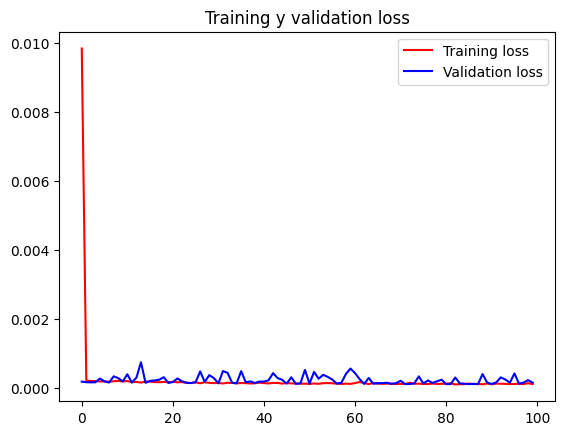

<Figure size 640x480 with 0 Axes>

In [16]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training y validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [17]:
### Lets Do the prediction and check performance metrics
train_predict=best_model_busq_aleatoria.predict(train_X)
test_predict=best_model_busq_aleatoria.predict(test_X)
train_predict.shape, test_predict.shape

39/39 [==============================] - 0s 8ms/step


((3716, 1), (1237, 1))

In [18]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(train_y.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(test_y.reshape(-1,1))

In [19]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [20]:
# Evaluation metrices RMSE, MAE and MAPE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MAPE: ", mape(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MAPE: ", mape(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  13.879602890758695
Train data MAPE:  0.831241696869425
Train data MAE:  9.655164491257189
-------------------------------------------------------------------------------------
Test data RMSE:  17.79276959891357
Test data MAPE:  0.7685392068408642
Test data MAE:  13.140968086063811


In [22]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Precio original','Precio predicho Train','Precio predicho Test'])


plotdf = pd.DataFrame({'date': close_stock['Time'],
                       'original_close': close_stock['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Precio (USD)','date': 'Fecha'})
fig.update_layout(title_text='Comparación entre precio original de cierre y precio predicho de cierre',
                  plot_bgcolor='white', font_size=14, font_color='black', legend_title_text='Precio cierre')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (4961, 1)
Test predicted data:  (4961, 1)
